In [1]:
import hdbscan
import os
import glob
import numpy as np
import sys
import pandas as pd
from pandas import DataFrame
import nibabel as nib
import umap.umap_ as UMAP

import matplotlib.pyplot as plt
#matplotlib inline
import seaborn as sns
from umap_outils import create_umap_input
from umap_outils import train_umap
from umap_outils import plot_umap
#from umap_outils import plot_clusters_umap

In [2]:
# Replace 'your_file.csv' with the actual file path
file_path = '/data/extra/movando/umap/umap_all_participants/all_ttest_101/commisural/umap_all_combined_101part.csv'

# Read the CSV file into a DataFrame
X_embedded = pd.read_csv(file_path, header=None)

# Display the DataFrame
print(X_embedded)

                0         1
0      -12.018925  4.191184
1      -12.044818  4.103938
2      -11.566514  4.519220
3      -12.224920  3.897627
4      -12.193686  4.180676
...           ...       ...
215125 -11.755620  3.468276
215126 -12.468338  4.256964
215127 -12.253728  3.729850
215128 -11.935596  4.699200
215129 -12.791490  3.268074

[215130 rows x 2 columns]


In [3]:
print(X_embedded.shape)
x_axes = X_embedded.iloc[:, 0]
y_axes = X_embedded.iloc[:, 1]



(215130, 2)


/homes_unix/movando/umap_outils.py:74: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_axis, y_axis, s=0.01, cmap="plasma", alpha=0.5)


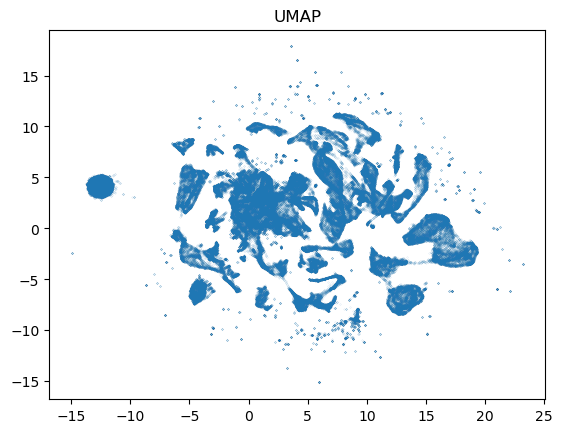

In [4]:
plot_umap(x_axes,y_axes)


In [5]:
np.random.seed(42)
clustered_data = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=50, min_samples= 400, gen_min_span_tree=True).fit(X_embedded)
print(clustered_data)


HDBSCAN(gen_min_span_tree=True, min_cluster_size=50, min_samples=400)


In [6]:
# Get the labels from the clustering
labels = clustered_data.labels_

# Calculate validity index
#vi = hdbscan.validity.validity_index(X_embedded2, labels)

# Calculate the DBCV score
dbcv_score = clustered_data.relative_validity_
              
# You can also access other results, such as coverage and total clusters
clustered = (labels >= 0)
coverage = np.sum(clustered) / X_embedded.shape[0]
total_clusters = np.max(labels)

# Print or use the validity index as needed
print("dbcv_score:", dbcv_score)
#print("Validity Index:", vi)
print("coverage:", coverage)
print("total_clusters",total_clusters)



dbcv_score: 0.5038572171397316
coverage: 0.898075582206108
total_clusters 40


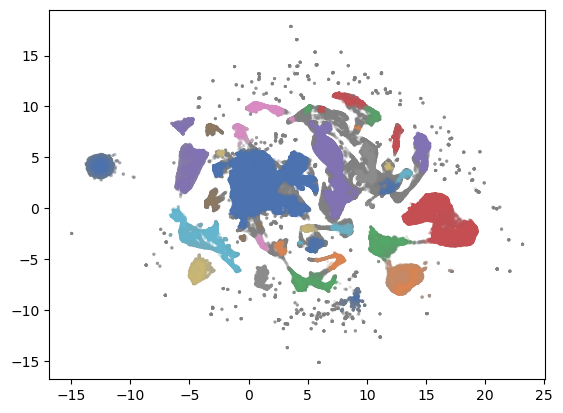

In [9]:
    num_clusters = clustered_data.labels_.max() + 1
    color_palette = sns.color_palette('deep', n_colors=num_clusters)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clustered_data.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clustered_data.probabilities_)]
    plt.scatter(x_axes, y_axes, s=5, linewidth=0, c=cluster_member_colors, alpha=0.25)
    plt.show()

In [10]:
np.savetxt('/data/extra/movando/umap/umap_all_participants/all_ttest_101/commisural/cluster_labels_50-400_test.txt', clustered_data.labels_ , fmt='%f')

# txt file with all coordinates of MNI space (for each voxel)

#mytxtfile = 'articulatory_inverse_transformation.txt'
cluster = '/data/extra/movando/umap/umap_all_participants/all_ttest_101/commisural/cluster_labels_50-400_test.txt'

#vect = np.genfromtxt(mytxtfile)

vect1	=	np.genfromtxt(cluster)

#maskF= "/data/extra/movando/umap/cerebellum_excluded_mni_mask.nii.gz"
maskF= "/data/extra/movando/umap/mask/r00MNI152_wskullBrainExtractionMask.nii.gz"
maskIm = nib.load(maskF)
mask = maskIm.get_fdata().astype(bool)

vol1 = np.zeros(mask.shape)

vol1[mask] = vect1

volIm1 = nib.Nifti1Image(vol1, maskIm.affine)

#nib.save(volIm, 'articulatory_inv.nii.gz')
nib.save(volIm1, '/data/extra/movando/umap/umap_all_participants/all_ttest_101/commisural/hdbscan_50-400_clusters_test.nii.gz')

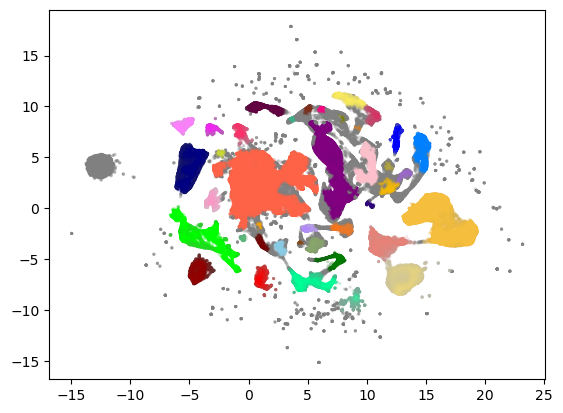

In [7]:

# Define custom RGB colors for parcels 1 to 40
rgb_colors = [
    (232, 213, 129), (232, 130, 120), (245, 190, 60), (255, 128, 255), (255, 31, 255),
    (255, 49, 106), (255, 0, 0), (150, 0, 0), (0, 255, 0), (65, 230, 160), (0, 124, 0),
    (0, 255, 151), (0, 0, 255), (0, 0, 131), (255, 151, 198), (100, 3, 66), (46, 3, 128),
    (176, 137, 255), (139, 69, 19), (135, 169, 107), (205, 127, 50), (222, 49, 99),
    (251, 236, 93), (0, 128, 255), (80, 200, 120), (62, 180, 137), (128, 128, 0), (209, 226, 49),
    (255, 117, 24), (255, 99, 71), (135, 206, 235), (136, 45, 23), (255, 0, 127), (128, 0, 128),
    (255, 165, 0), (128, 0, 0), (255, 192, 203), (181, 166, 66), (153, 102, 204), (255, 191, 0)
]

# Normalize the RGB values to the range [0, 1] for use in matplotlib
normalized_colors = [(r/255, g/255, b/255) for r, g, b in rgb_colors]

# Define the zero color as grey
zero_color = (0.5, 0.5, 0.5)  # grey

# Number of clusters (should be 37 to include the zero cluster)
num_clusters = 41

# Ensure the number of colors matches the number of clusters
custom_palette = [zero_color] + normalized_colors  # First color is grey for zero

# Clustered data labels and probabilities
# Assuming 'clustered_data.labels_' and 'clustered_data.probabilities_' are already defined
cluster_colors = [custom_palette[x] if x >= 0 else zero_color
                  for x in clustered_data.labels_]

# Modify colors based on the probability of each cluster member
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clustered_data.probabilities_)]

# Scatter plot
plt.scatter(x_axes, y_axes, s=5, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()